In [1]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max.columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

In [3]:
df = pd.read_csv('data/for_ship_model.csv')

In [4]:
df.columns = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호', '접안_대기시간_분',
       '계선장소명', '선박용도', 'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

x_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour',
       'Service_Time_분', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
        '파주기', '파향', '이전_입항선박수','시설연평균_재화중량톤수', 
        '연평균_총입항건수', '선박_연평균_서비스시간', '계선장소명_encoded', '선박용도_encoded']

display_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', 
       'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간', 
        '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향','접안_대기시간_분']
df.head(2)

,ETA_Year,ETA_Month,ETA_Day,ETA_Hour,호출부호,접안_대기시간_분,계선장소명,선박용도,Service_Time_분,대기율,총톤수,재화중량톤수,선박_총길이,선박_너비,선박_만재흘수,선박_깊이,선박_길이1,풍속,풍향,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,파향,이전_입항선박수,연도별_선석점유율,시설연평균_재화중량톤수,연평균_총입항건수,선박_연평균_서비스시간,선박_연평균_대기시간,호출부호_encoded,계선장소명_encoded,선박용도_encoded
0,2020,1,1,1,88238,0,SK2부두 01,석유제품 운반선,430.0,0.0,700.0,0.0,70.9,12.0,3.9,5.35,66.01,9.3,330.0,12.2,1028.8,43.0,4.3,17.5,4.2,2.8,2.0,10.7,49.0,0,4.143219,2073.888986,1729.000000,1452.987426,572.048817,0,0,0
1,2020,1,1,3,DSRB9,0,가스부두,LPG 운반선,710.0,0.0,2689.0,2999.0,96.0,15.0,7.2,7.20,90.10,12.6,315.0,15.3,1028.5,44.0,4.3,17.4,3.9,2.2,1.5,9.1,48.0,0,1.742879,3935.463021,418.333333,970.370370,215.740741,1,1,1


In [5]:
df[display_cols].sample(7)

,ETA_Year,ETA_Month,ETA_Day,ETA_Hour,Service_Time_분,대기율,총톤수,재화중량톤수,선박_총길이,선박_너비,선박_만재흘수,선박_깊이,선박_길이1,이전_입항선박수,연도별_선석점유율,시설연평균_재화중량톤수,연평균_총입항건수,선박_연평균_서비스시간,선박_연평균_대기시간,풍속,풍향,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,파향,접안_대기시간_분
18591,2021,2,9,23,95.0,0.000000,187.0,582.0,40.34,7.8,3.5,3.60,40.34,1,1.800036,10695.145021,316.000000,529.030317,171.176471,6.4,279.0,10.2,1024.9,42.0,8.7,15.0,2.1,1.3,0.9,7.1,46.0,0
8507,2020,7,2,22,1175.0,0.000000,1130.0,2286.0,70.30,11.2,5.0,5.95,74.00,3,4.143219,2073.888986,1729.000000,1401.490986,0.000000,3.7,224.0,4.7,1013.9,84.0,22.3,22.0,2.8,1.1,0.8,8.0,177.0,0
40936,2022,5,23,13,1530.0,0.000000,499.0,1145.0,61.10,10.0,4.0,4.50,60.90,0,1.403806,12355.357971,100.666667,1059.789572,417.710428,3.2,110.0,3.9,1013.4,86.0,20.5,20.1,0.7,0.4,0.3,4.9,319.0,0
32794,2021,12,9,12,2065.0,0.000000,29760.0,49990.0,183.30,32.2,13.0,19.10,175.60,2,3.625837,6519.097016,725.333333,2560.625000,1606.500000,5.1,69.0,6.7,1030.1,65.0,17.7,17.8,2.1,1.2,0.9,8.0,72.0,0
18801,2021,2,14,20,870.0,0.000000,3872.0,1172.0,97.00,16.0,5.5,7.30,90.17,1,1.742879,3935.463021,418.333333,1409.340278,0.000000,4.4,181.0,5.4,1012.0,81.0,14.9,15.6,0.8,0.6,0.4,5.3,172.0,0
26296,2021,7,25,10,1220.0,474.590164,3038.0,4710.0,99.86,15.2,6.2,7.60,93.31,2,4.031303,5535.810444,488.000000,2854.489583,1019.197917,3.7,123.0,4.7,1007.9,85.0,29.4,27.8,0.8,0.5,0.4,10.7,227.0,5790
49738,2022,12,2,19,2550.0,0.000000,3038.0,4710.0,99.86,15.2,6.2,7.60,93.31,0,2.436745,11045.521196,25.333333,2854.489583,1019.197917,1.2,19.0,5.1,1028.6,44.0,8.4,20.0,1.9,1.1,0.8,7.1,28.0,0


In [6]:
df[display_cols].iloc[:, :4].tail(7)

,ETA_Year,ETA_Month,ETA_Day,ETA_Hour
50994,2022,12,31,8
50995,2022,12,31,8
50996,2022,12,31,9
50997,2022,12,31,9
50998,2022,12,31,10
50999,2022,12,31,15
51000,2022,12,31,17


In [7]:
df[x_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51001 entries, 0 to 51000
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ETA_Year        51001 non-null  int64  
 1   ETA_Month       51001 non-null  int64  
 2   ETA_Day         51001 non-null  int64  
 3   ETA_Hour        51001 non-null  int64  
 4   Service_Time_분  51001 non-null  float64
 5   총톤수             51001 non-null  float64
 6   재화중량톤수          51001 non-null  float64
 7   선박_총길이          51001 non-null  float64
 8   선박_너비           51001 non-null  float64
 9   선박_만재흘수         51001 non-null  float64
 10  선박_깊이           51001 non-null  float64
 11  풍속              51001 non-null  float64
 12  풍향              51001 non-null  float64
 13  GUST풍속          51001 non-null  float64
 14  현지기압            51001 non-null  float64
 15  습도              51001 non-null  float64
 16  기온              51001 non-null  float64
 17  수온              51001 non-null 

## 1차 : base+kfold (182.85)

In [8]:
from sklearn.model_selection import KFold

# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.3),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.9),  # feature_fraction의 범위 설정
    'max_depth': (3, 15),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1)              # reg_lambda의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0)
    }

    kf = KFold(n_splits=10, random_state=12, shuffle=True)
    rmses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMRegressor(**params)

        # 모델 학습
        model.fit(X_train, y_train)

        # 검증 데이터로 예측
        y_pred = model.predict(X_val)

        # 모델 평가 (RMSE 계산)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return -np.mean(rmses)  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=42,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)

# 최적 하이퍼파라미터로 모델 학습 및 평가
kf = KFold(n_splits=10, random_state=12, shuffle=True)
test_rmses = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    best_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=int(best_params['num_leaves']),
        learning_rate=best_params['learning_rate'],
        feature_fraction=best_params['feature_fraction'],
        min_child_samples=int(best_params['min_child_samples']),
        reg_lambda=best_params['reg_lambda']
    )

    # 모델 학습
    best_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = best_model.predict(X_val)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    test_rmses.append(rmse)


# 예측 결과값의 범위 출력
print("예측 결과값 범위:")
print(f"최소 예측값: {np.min(y_pred)}")
print(f"최대 예측값: {np.max(y_pred)}")

print(f'평균 검증 RMSE (최적 모델): {np.mean(test_rmses)}')

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.3996320

## 2차 : n_iter(10->>15) (182.85)

In [9]:
from sklearn.model_selection import KFold

# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.3),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.9),  # feature_fraction의 범위 설정
    'max_depth': (3, 15),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1)              # reg_lambda의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0)
    }

    kf = KFold(n_splits=10, random_state=12, shuffle=True)
    rmses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMRegressor(**params)

        # 모델 학습
        model.fit(X_train, y_train)

        # 검증 데이터로 예측
        y_pred = model.predict(X_val)

        # 모델 평가 (RMSE 계산)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return -np.mean(rmses)  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=12,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=15)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)

# 최적 하이퍼파라미터로 모델 학습 및 평가
kf = KFold(n_splits=10, random_state=12, shuffle=True)
test_rmses = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    best_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=int(best_params['num_leaves']),
        learning_rate=best_params['learning_rate'],
        feature_fraction=best_params['feature_fraction'],
        min_child_samples=int(best_params['min_child_samples']),
        reg_lambda=best_params['reg_lambda']
    )

    # 모델 학습
    best_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = best_model.predict(X_val)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    test_rmses.append(rmse)


# 예측 결과값의 범위 출력
print("예측 결과값 범위:")
print(f"최소 예측값: {np.min(y_pred)}")
print(f"최대 예측값: {np.max(y_pred)}")

print(f'평균 검증 RMSE (최적 모델): {np.mean(test_rmses)}')

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.2233302739037379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2233302739037379
[LightGBM] [Warning] feature_fraction is set=0.2233302739037379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2233302739037379
[LightGBM] [Warning] feature_fraction is set=0.2233302739037379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2233302739037379
[LightGBM] [Warning] feature_fraction is set=0.2233302739037379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2233302739037379
[LightGBM] [Warning] feature_fraction is set=0.2233302739037379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2233302739037379
[LightGBM] [Warning] feature_fract

## 3차 : 파라미터 추가
- subsample , colsample by tree

In [10]:
# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.3),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.9),  # feature_fraction의 범위 설정
    'max_depth': (3, 15),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1),              # reg_lambda의 범위 설정
    #'max_bin': (5, 500),              # max_bin의 범위 설정
    'subsample': (0.5, 1.0),          # subsample의 범위 설정
    'colsample_bytree': (0.5, 1.0)    # colsample_bytree의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda, subsample, colsample_bytree):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0),
       # 'max_bin': int(max_bin),
        'subsample': max(min(subsample, 1), 0),
        'colsample_bytree': max(min(colsample_bytree, 1), 0)
    }

    model = lgb.LGBMRegressor(**params)

    # 모델 학습
    model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = model.predict(X_test)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return -rmse  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=12,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)



# 최적 하이퍼파라미터로 모델 학습 및 평가
best_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    feature_fraction=best_params['feature_fraction'],
    min_child_samples=int(best_params['min_child_samples']),
    reg_lambda=best_params['reg_lambda'],
    # max_bin=int(best_params['max_bin']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree']
)


best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'테스트 RMSE (최적 모델): {test_rmse}')

|   iter    |  target   | colsam... | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.6920397572123238, colsample_bytree=0.5770814211898362 will be ignored. Current value: feature_fraction=0.6920397572123238
| 1         | -1.038e+0 | 0.5771    | 0.692     | 0.08636   | 9.405     | 1.714     | 92.04     | 0.9007    | 0.5167    |
[LightGBM] [Warning] feature_fraction is set=0.20976745708486116, colsample_bytree=0.9784746681375585 will be ignored. Current value: feature_fraction=0.20976745708486116
| 2         | -1.035e+0 | 0.9785    | 0.2098    | 0.09231   | 10.27     | 47.27     | 85.57     | 0.002259  | 0.7606    |
[LightGBM] [Warning] feature_fraction is set=0.4883019309301678, colsample_bytree=0.7760188166322832 will be ignored. Current value: feature_fraction=0.4883019309301678
| 3

|   iter    |  target   | colsam... | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.6920397572123238, colsample_bytree=0.5770814211898362 will be ignored. Current value: feature_fraction=0.6920397572123238
RMSE: 1037.6248473482353, MAE: 489.8072823302879
| 1         | -1.038e+0 | 0.5771    | 0.692     | 0.08636   | 9.405     | 1.714     | 92.04     | 0.9007    | 0.5167    |
[LightGBM] [Warning] feature_fraction is set=0.20976745708486116, colsample_bytree=0.9784746681375585 will be ignored. Current value: feature_fraction=0.20976745708486116
RMSE: 1035.102618019396, MAE: 498.57807366049497
| 2         | -1.035e+0 | 0.9785    | 0.2098    | 0.09231   | 10.27     | 47.27     | 85.57     | 0.002259  | 0.7606    |
[LightGBM] [Warning] feature_fraction is set=0.4883019309301678, colsample

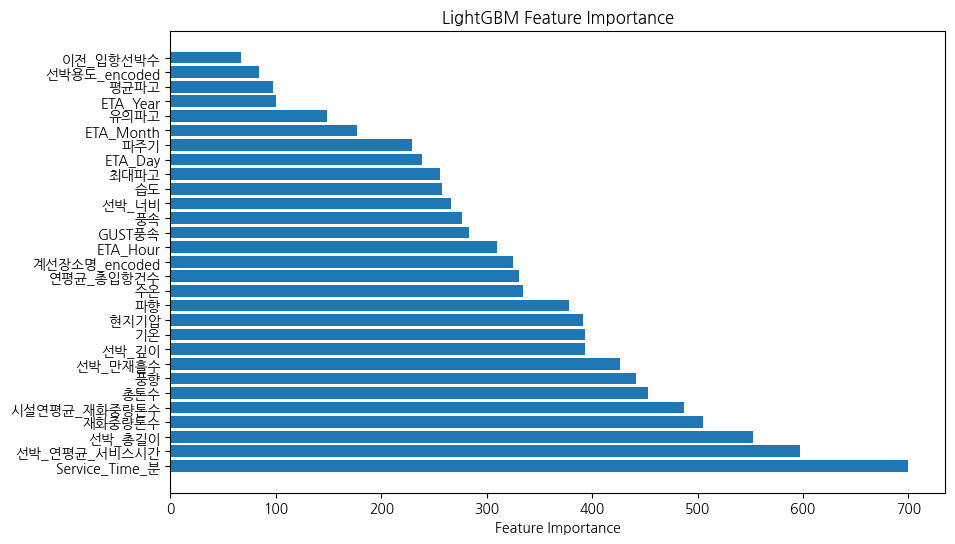

In [11]:
# 필요한 라이브러리 불러오기
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.3),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.9),  # feature_fraction의 범위 설정
    'max_depth': (3, 15),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1),              # reg_lambda의 범위 설정
    #'max_bin': (5, 500),              # max_bin의 범위 설정
    'subsample': (0.5, 1.0),          # subsample의 범위 설정
    'colsample_bytree': (0.5, 1.0)    # colsample_bytree의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda, subsample, colsample_bytree):
    params = {
        'objective': 'regression',
        'metric': 'rmse',  # Use RMSE as the default metric for optimization
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),
        'feature_fraction': max(min(feature_fraction, 1), 0),
        'max_depth': int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'colsample_bytree': max(min(colsample_bytree, 1), 0)
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Print RMSE and MAE for each iteration during optimization
    print(f'RMSE: {rmse}, MAE: {mae}')

    return -rmse  # Objective function is to minimize RMSE, so return its negative value
    model = lgb.LGBMRegressor(**params)

    # 모델 학습
    model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = model.predict(X_test)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return -rmse  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=12,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)



# 최적 하이퍼파라미터로 모델 학습 및 평가
best_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    feature_fraction=best_params['feature_fraction'],
    min_child_samples=int(best_params['min_child_samples']),
    reg_lambda=best_params['reg_lambda'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree']
)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# 테스트 RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f'테스트 RMSE (최적 모델): {test_rmse}')
print(f'테스트 MAE (최적 모델): {test_mae}')

# 피처 임포턴스 시각화
feature_importance = best_model.feature_importances_
feature_names = X.columns

feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_importance = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_feature_importance, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.show()